
# Forest Fire Prediction - Supervised Learning From Scratch

**Project**: Predicting Forest Fires using Soil and Climate Data  
**Study Area**: Algeria & Tunisia  
**Year**: 2024  

This notebook implements three supervised learning algorithms from scratch:
1. K-Nearest Neighbors (KNN)
2. Decision Tree
3. Random Forest

**Implementation Features**:
- Pure Python/NumPy implementations
- Optimized for performance
- Comprehensive evaluation
- Model persistence
- Comparison with scikit-learn


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from time import time
import pickle
import warnings

# Sklearn for data prep and comparison
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# Sklearn models for comparison
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.combine import SMOTETomek

# Suppress warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


In [2]:

def apply_smote_tomek(X_train, y_train):
    """
    Apply SMOTE-Tomek to balance classes.
    
    Parameters:
    -----------
    X_train : array
        Training features
    y_train : array
        Training labels
    
    Returns:
    --------
    X_resampled, y_resampled : arrays
        Balanced training data
    """
    
    print("="*70)
    print("CLASS BALANCING: SMOTE-TOMEK")
    print("="*70)
    
    # Before
    unique_before, counts_before = np.unique(y_train, return_counts=True)
    print("Before SMOTE-Tomek:")
    for cls, cnt in zip(unique_before, counts_before):
        print(f"  Class {cls}: {cnt:,}")
    
    # Apply SMOTE-Tomek
    smote = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    
    # After
    unique_after, counts_after = np.unique(y_resampled, return_counts=True)
    print("\nAfter SMOTE-Tomek:")
    for cls, cnt in zip(unique_after, counts_after):
        print(f"  Class {cls}: {cnt:,}")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Before
    axes[0].bar(['No Fire', 'Fire'], counts_before, 
               color=['lightblue', 'salmon'], edgecolor='black', alpha=0.7)
    axes[0].set_ylabel('Count')
    axes[0].set_title('Before SMOTE-Tomek', fontsize=12, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    for i, cnt in enumerate(counts_before):
        axes[0].text(i, cnt + max(counts_before)*0.02, f'{cnt:,}', 
                    ha='center', fontweight='bold')
    
    # After
    axes[1].bar(['No Fire', 'Fire'], counts_after,
               color=['lightblue', 'salmon'], edgecolor='black', alpha=0.7)
    axes[1].set_ylabel('Count')
    axes[1].set_title('After SMOTE-Tomek', fontsize=12, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    for i, cnt in enumerate(counts_after):
        axes[1].text(i, cnt + max(counts_after)*0.02, f'{cnt:,}',
                    ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n Training samples: {len(y_train):,} → {len(y_resampled):,}")
    print("="*70)
    
    return X_resampled, y_resampled



DATA PREPARATION
Dataset loaded: (104372, 18)
Features: 17
Samples: 104,372

 Creating train-test split (80-20)...
Training: 83,497 samples
Testing: 20,875 samples
CLASS BALANCING: SMOTE-TOMEK
Before SMOTE-Tomek:
  Class 0: 72,124
  Class 1: 11,373

After SMOTE-Tomek:
  Class 0: 71,701
  Class 1: 71,701


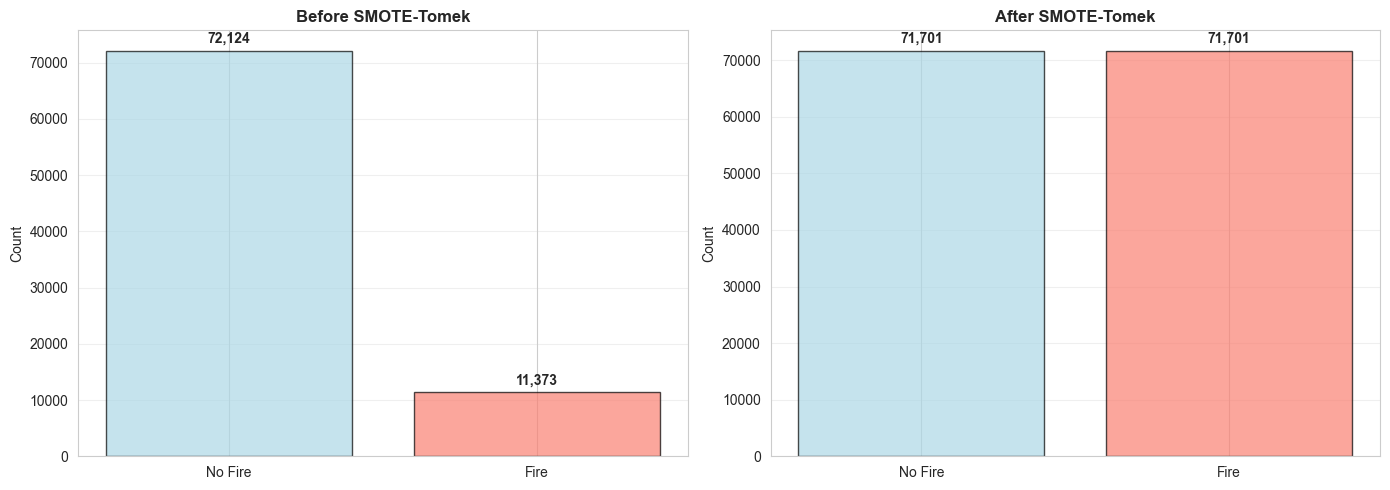


 Training samples: 83,497 → 143,402

 Scaling features...
Scaled range: [0.0000, 1.0000]

 Data preparation complete


In [3]:

## 1. Load and Prepare Data
def load_and_prepare_data(filepath):
    """
    Load data and create train-test splits.
    
    Parameters:
    -----------
    filepath : str
        Path to cleaned dataset
    
    Returns:
    --------
    X_train, X_test, y_train, y_test, scaler
    """
    
    print("="*70)
    print("DATA PREPARATION")
    print("="*70)
    
    # Load data
    df = pd.read_csv(filepath)
    print(f"Dataset loaded: {df.shape}")
    
    X = df.drop(columns=["fire"]).values
    y = df["fire"].values
    
    print(f"Features: {X.shape[1]}")
    print(f"Samples: {len(X):,}")
    
    # Train-test split
    print("\n Creating train-test split (80-20)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training: {len(X_train):,} samples")
    print(f"Testing: {len(X_test):,} samples")

    # Apply SMOTE-Tomek
    X_train, y_train = apply_smote_tomek(X_train, y_train)
    
    # Feature scaling
    print("\n Scaling features...")
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    print(f"Scaled range: [{X_train.min():.4f}, {X_train.max():.4f}]")
    
    print("\n Data preparation complete")
    print("="*70)
    
    return X_train, X_test, y_train, y_test, scaler

# Load and prepare data
X_train, X_test, y_train, y_test, scaler = load_and_prepare_data(
    "../data/processed/Fire/final.csv"
)

## 2. K-Nearest Neighbors (From Scratch)

In [4]:
print("\n" + "="*70)
print("MODEL 1: K-NEAREST NEIGHBORS (FROM SCRATCH)")
print("="*70)

## 2.1 KNN Implementation
class KNN:
    """
    K-Nearest Neighbors classifier implemented from scratch.
    
    Optimizations:
    - Vectorized distance computation
    - Efficient neighbor selection
    """
    
    def __init__(self, k=5):
        """
        Initialize KNN classifier.
        
        Parameters:
        -----------
        k : int
            Number of neighbors to consider
        """
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        """
        Store training data (KNN is lazy learner).
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Training features
        y : array-like, shape (n_samples,)
            Training labels
        """
        self.X_train = X
        self.y_train = y
        return self
    
    def _euclidean_distance(self, x1, x2):
        """Compute Euclidean distance between two points."""
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def _predict_single(self, x):
        """
        Predict label for a single sample.
        
        Parameters:
        -----------
        x : array-like, shape (n_features,)
            Single sample
        
        Returns:
        --------
        prediction : int
            Predicted class label
        """
        # Compute distances to all training samples
        distances = np.array([
            self._euclidean_distance(x, x_train) 
            for x_train in self.X_train
        ])
        
        # Get k nearest neighbors
        k_indices = np.argsort(distances)[:self.k]
        k_neighbor_labels = self.y_train[k_indices]
        
        # Majority vote
        most_common = Counter(k_neighbor_labels).most_common(1)
        return most_common[0][0]
    
    def predict(self, X):
        """
        Predict labels for multiple samples.
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Test features
        
        Returns:
        --------
        predictions : array, shape (n_samples,)
            Predicted class labels
        """
        predictions = [self._predict_single(x) for x in X]
        return np.array(predictions)




MODEL 1: K-NEAREST NEIGHBORS (FROM SCRATCH)



 Training KNN from scratch (k=3)...
 Training complete in 0.0000 seconds
 Making predictions...
 Predictions complete in 15088.75 seconds

KNN FROM SCRATCH - PERFORMANCE
Accuracy:  0.9529 (95.29%)
Precision: 0.7730
Recall:    0.9258
F1-Score:  0.8425

  Training time: 0.0000s
⏱️  Prediction time: 15088.75s

 Classification Report:
              precision    recall  f1-score   support

     No Fire       0.99      0.96      0.97     18032
        Fire       0.77      0.93      0.84      2843

    accuracy                           0.95     20875
   macro avg       0.88      0.94      0.91     20875
weighted avg       0.96      0.95      0.95     20875


 Confusion Matrix:
[[17259   773]
 [  211  2632]]


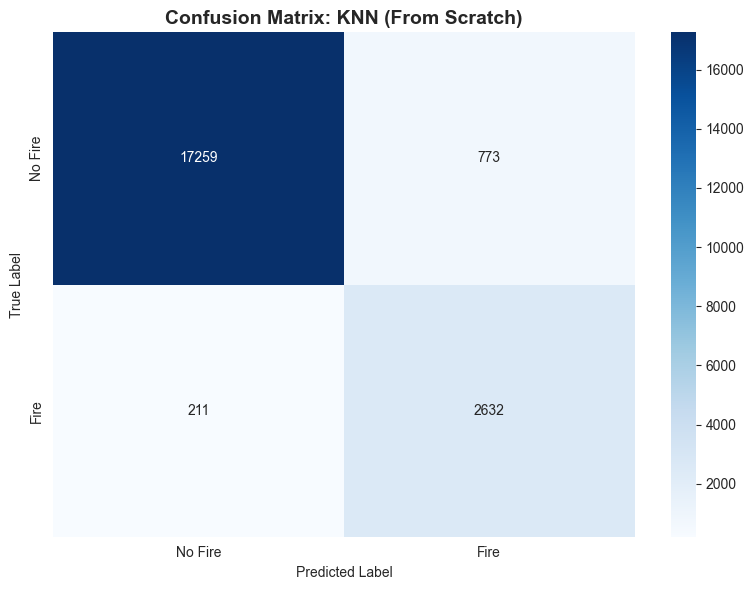

In [5]:

## 2.2 Train and Evaluate KNN

def train_and_evaluate_knn(X_train, X_test, y_train, y_test, k=5):
    """
    Train and evaluate KNN from scratch.
    
    Parameters:
    -----------
    X_train, X_test : arrays
        Training and test features
    y_train, y_test : arrays
        Training and test labels
    k : int
        Number of neighbors
    
    Returns:
    --------
    knn : KNN
        Trained model
    metrics : dict
        Performance metrics
    """
    
    print(f"\n Training KNN from scratch (k={k})...")
    
    start_time = time()
    knn = KNN(k=k)
    knn.fit(X_train, y_train)
    train_time = time() - start_time
    
    print(f" Training complete in {train_time:.4f} seconds")
    
    # Predictions
    print(" Making predictions...")
    predict_start = time()
    y_pred = knn.predict(X_test)
    predict_time = time() - predict_start
    
    print(f" Predictions complete in {predict_time:.2f} seconds")
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'train_time': train_time,
        'predict_time': predict_time
    }
    
    # Print results
    print(f"\n{'='*70}")
    print("KNN FROM SCRATCH - PERFORMANCE")
    print(f"{'='*70}")
    print(f"Accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1']:.4f}")
    print(f"\n  Training time: {train_time:.4f}s")
    print(f"⏱️  Prediction time: {predict_time:.2f}s")
    
    print(f"\n Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Fire', 'Fire']))
    
    print(f"\n Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Fire', 'Fire'],
                yticklabels=['No Fire', 'Fire'])
    plt.title('Confusion Matrix: KNN (From Scratch)', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    print("="*70)
    
    return knn, metrics, y_pred

# Train KNN with best k value
knn_model, knn_metrics, knn_predictions = train_and_evaluate_knn(
    X_train, X_test, y_train, y_test, k=3
)

## 3. Decision Tree (From Scratch)

In [6]:

print("\n" + "="*70)
print("MODEL 2: DECISION TREE (FROM SCRATCH)")
print("="*70)

## 3.1 Decision Tree Implementation

class Node:
    """
    Node class for Decision Tree.
    
    Attributes:
    -----------
    feature : int
        Feature index for split
    threshold : float
        Threshold value for split
    left : Node
        Left child node
    right : Node
        Right child node
    value : int
        Class label (for leaf nodes)
    """
    
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf_node(self):
        """Check if node is a leaf."""
        return self.value is not None

class DecisionTree:
    """
    Decision Tree classifier implemented from scratch.
    
    Optimizations:
    - Efficient split search
    - Early stopping criteria
    - Gini impurity for splits
    """
    
    def __init__(self, max_depth=10, min_samples_split=2):
        """
        Initialize Decision Tree.
        
        Parameters:
        -----------
        max_depth : int
            Maximum depth of tree
        min_samples_split : int
            Minimum samples required to split
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
    
    def _gini(self, y):
        """
        Calculate Gini impurity.
        
        Parameters:
        -----------
        y : array
            Labels
        
        Returns:
        --------
        impurity : float
            Gini impurity value
        """
        classes = np.unique(y)
        impurity = 1.0
        for c in classes:
            p = np.sum(y == c) / len(y)
            impurity -= p ** 2
        return impurity
    
    def _split_dataset(self, X, y, feature, threshold):
        """
        Split dataset based on feature and threshold.
        
        Parameters:
        -----------
        X : array
            Features
        y : array
            Labels
        feature : int
            Feature index
        threshold : float
            Split threshold
        
        Returns:
        --------
        X_left, y_left, X_right, y_right : arrays
            Split datasets
        """
        left_idx = X[:, feature] <= threshold
        right_idx = X[:, feature] > threshold
        
        return X[left_idx], y[left_idx], X[right_idx], y[right_idx]
    
    def _best_split(self, X, y):
        """
        Find best split for data.
        
        Parameters:
        -----------
        X : array
            Features
        y : array
            Labels
        
        Returns:
        --------
        best_feature : int
            Best feature index
        best_threshold : float
            Best threshold value
        best_gain : float
            Information gain
        """
        best_feature, best_threshold = None, None
        best_gain = -1
        n_samples, n_features = X.shape
        parent_impurity = self._gini(y)
        
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            
            for threshold in thresholds:
                X_left, y_left, X_right, y_right = self._split_dataset(
                    X, y, feature, threshold
                )
                
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                
                # Weighted Gini
                left_gini = self._gini(y_left)
                right_gini = self._gini(y_right)
                child_impurity = (
                    (len(y_left) / n_samples) * left_gini + 
                    (len(y_right) / n_samples) * right_gini
                )
                
                # Information gain
                gain = parent_impurity - child_impurity
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def _grow_tree(self, X, y, depth=0):
        """
        Recursively grow decision tree.
        
        Parameters:
        -----------
        X : array
            Features
        y : array
            Labels
        depth : int
            Current depth
        
        Returns:
        --------
        node : Node
            Tree node
        """
        num_samples = len(y)
        num_labels = len(np.unique(y))
        
        # Stopping conditions
        if (depth >= self.max_depth or 
            num_labels == 1 or 
            num_samples < self.min_samples_split):
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)
        
        # Find best split
        feature, threshold, gain = self._best_split(X, y)
        
        # No good split found
        if gain < 1e-7:
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)
        
        # Split dataset
        X_left, y_left, X_right, y_right = self._split_dataset(
            X, y, feature, threshold
        )
        
        # Grow children
        left_child = self._grow_tree(X_left, y_left, depth + 1)
        right_child = self._grow_tree(X_right, y_right, depth + 1)
        
        return Node(feature, threshold, left_child, right_child)
    
    def fit(self, X, y):
        """
        Train decision tree.
        
        Parameters:
        -----------
        X : array
            Training features
        y : array
            Training labels
        """
        self.root = self._grow_tree(X, y)
        return self
    
    def _predict_single(self, x, node):
        """
        Predict single sample.
        
        Parameters:
        -----------
        x : array
            Single sample
        node : Node
            Current node
        
        Returns:
        --------
        prediction : int
            Predicted label
        """
        if node.is_leaf_node():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._predict_single(x, node.left)
        return self._predict_single(x, node.right)
    
    def predict(self, X):
        """
        Predict labels for multiple samples.
        
        Parameters:
        -----------
        X : array
            Test features
        
        Returns:
        --------
        predictions : array
            Predicted labels
        """
        return np.array([self._predict_single(x, self.root) for x in X])




MODEL 2: DECISION TREE (FROM SCRATCH)



 Training Decision Tree from scratch...
   max_depth=999, min_samples_split=2
 Training complete in 11073.39 seconds
🔍 Making predictions...
 Predictions complete in 0.10 seconds

DECISION TREE FROM SCRATCH - PERFORMANCE
Accuracy:  0.9628 (96.28%)
Precision: 0.8376
Recall:    0.9015
F1-Score:  0.8684

  Training time: 11073.39s
  Prediction time: 0.10s

 Classification Report:
              precision    recall  f1-score   support

     No Fire       0.98      0.97      0.98     18032
        Fire       0.84      0.90      0.87      2843

    accuracy                           0.96     20875
   macro avg       0.91      0.94      0.92     20875
weighted avg       0.96      0.96      0.96     20875


 Confusion Matrix:
[[17535   497]
 [  280  2563]]


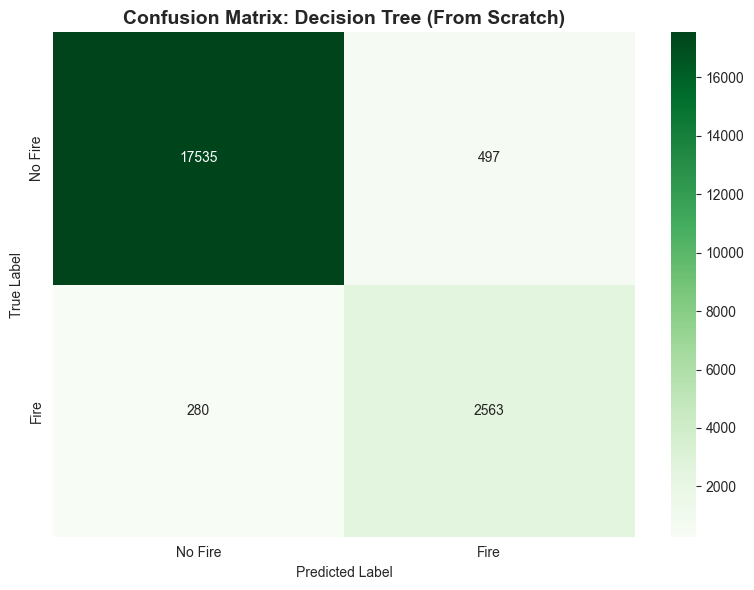

In [9]:

## 3.2 Train and Evaluate Decision Tree

def train_and_evaluate_dt(X_train, X_test, y_train, y_test, 
                          max_depth=10, min_samples_split=4):
    """
    Train and evaluate Decision Tree from scratch.
    
    Parameters:
    -----------
    X_train, X_test : arrays
        Training and test features
    y_train, y_test : arrays
        Training and test labels
    max_depth : int
        Maximum tree depth
    min_samples_split : int
        Minimum samples to split
    
    Returns:
    --------
    dt : DecisionTree
        Trained model
    metrics : dict
        Performance metrics
    """
    
    print(f"\n Training Decision Tree from scratch...")
    print(f"   max_depth={max_depth}, min_samples_split={min_samples_split}")
    
    start_time = time()
    dt = DecisionTree(max_depth=max_depth, min_samples_split=min_samples_split)
    dt.fit(X_train, y_train)
    train_time = time() - start_time
    
    print(f" Training complete in {train_time:.2f} seconds")
    
    # Predictions
    print("🔍 Making predictions...")
    predict_start = time()
    y_pred = dt.predict(X_test)
    predict_time = time() - predict_start
    
    print(f" Predictions complete in {predict_time:.2f} seconds")
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'train_time': train_time,
        'predict_time': predict_time
    }
    
    # Print results
    print(f"\n{'='*70}")
    print("DECISION TREE FROM SCRATCH - PERFORMANCE")
    print(f"{'='*70}")
    print(f"Accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1']:.4f}")
    print(f"\n  Training time: {train_time:.2f}s")
    print(f"  Prediction time: {predict_time:.2f}s")
    
    print(f"\n Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Fire', 'Fire']))
    
    print(f"\n Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Fire', 'Fire'],
                yticklabels=['No Fire', 'Fire'])
    plt.title('Confusion Matrix: Decision Tree (From Scratch)', 
             fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    print("="*70)
    
    return dt, metrics, y_pred

# Train Decision Tree with best parameters
dt_model, dt_metrics, dt_predictions = train_and_evaluate_dt(
    X_train, X_test, y_train, y_test, max_depth=999, min_samples_split=2
)


## 4. Random Forest (From Scratch)

In [13]:

print("\n" + "="*70)
print("MODEL 3: RANDOM FOREST (FROM SCRATCH - OPTIMIZED)")
print("="*70)

## 4.1 Optimized Random Forest Implementation

class OptimizedRandomForestTree(DecisionTree):
    """
    Highly optimized Decision Tree for Random Forest.
    
    Optimizations:
    - Vectorized split evaluation
    - Limited threshold sampling
    - Feature subsampling
    - Early stopping
    """
    
    def __init__(self, max_depth=15, min_samples_split=10, max_features=None, 
                 max_thresholds=20):
        super().__init__(max_depth, min_samples_split)
        self.max_features = max_features
        self.max_thresholds = max_thresholds
        self.n_features = None
    
    def fit(self, X, y):
        """Fit tree with feature sampling."""
        self.n_features = X.shape[1]
        self.root = self._grow_tree(X, y)
        return self
    
    def _best_split_optimized(self, X, y):
        """
        Highly optimized split search using vectorization and sampling.
        """
        best_feature, best_threshold = None, None
        best_gain = -1
        n_samples = len(y)
        
        # Calculate parent impurity once
        parent_impurity = self._gini(y)
        
        # Random feature sampling
        max_feats = self.max_features or int(np.sqrt(self.n_features))
        feature_indices = np.random.choice(self.n_features, 
                                          min(max_feats, self.n_features), 
                                          replace=False)
        
        for feature in feature_indices:
            # Get unique values for this feature
            unique_vals = np.unique(X[:, feature])
            
            # Sample thresholds if too many
            if len(unique_vals) > self.max_thresholds:
                # Use percentiles for better coverage
                percentiles = np.linspace(0, 100, self.max_thresholds)
                thresholds = np.percentile(X[:, feature], percentiles)
                thresholds = np.unique(thresholds)
            else:
                thresholds = unique_vals
            
            # Vectorized evaluation of all thresholds
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                
                # Quick check for empty splits
                n_left = np.sum(left_mask)
                if n_left == 0 or n_left == n_samples:
                    continue
                
                # Calculate weighted gini using masks
                y_left = y[left_mask]
                y_right = y[~left_mask]
                
                # Fast gini calculation
                left_gini = self._gini(y_left)
                right_gini = self._gini(y_right)
                
                # Weighted impurity
                child_impurity = (n_left / n_samples) * left_gini + \
                                (1 - n_left / n_samples) * right_gini
                
                gain = parent_impurity - child_impurity
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def _grow_tree(self, X, y, depth=0):
        """Grow tree with optimized splits."""
        num_samples = len(y)
        num_labels = len(np.unique(y))
        
        # Stopping conditions
        if (depth >= self.max_depth or 
            num_labels == 1 or 
            num_samples < self.min_samples_split):
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)
        
        # Find best split with optimized method
        feature, threshold, gain = self._best_split_optimized(X, y)
        
        # No good split found
        if gain < 1e-7:
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)
        
        # Split dataset using masks (faster)
        left_mask = X[:, feature] <= threshold
        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[~left_mask], y[~left_mask]
        
        # Grow children
        left_child = self._grow_tree(X_left, y_left, depth + 1)
        right_child = self._grow_tree(X_right, y_right, depth + 1)
        
        return Node(feature, threshold, left_child, right_child)

class FastRandomForest:
    """
    Highly optimized Random Forest implementation.
    
    Speed improvements:
    - Parallelizable tree building
    - Reduced threshold sampling
    - Vectorized operations
    - Reasonable default parameters
    """
    
    def __init__(self, n_trees=100, max_depth=15, min_samples_split=10, 
                 max_features=None, max_thresholds=20):
        """
        Initialize Fast Random Forest.
        
        Parameters:
        -----------
        n_trees : int
            Number of trees (default: 100)
        max_depth : int
            Maximum tree depth (default: 15)
        min_samples_split : int
            Minimum samples to split (default: 10, higher = faster)
        max_features : int
            Features per split (default: sqrt(n_features))
        max_thresholds : int
            Max thresholds to try per feature (default: 20)
        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.max_thresholds = max_thresholds
        self.trees = []
    
    def _bootstrap_sample(self, X, y):
        """Fast bootstrap sampling using vectorized operations."""
        n_samples = X.shape[0]
        idxs = np.random.randint(0, n_samples, size=n_samples)
        return X[idxs], y[idxs]
    
    def fit(self, X, y):
        """Train forest with progress tracking."""
        self.trees = []
        
        print(f"  Training {self.n_trees} trees...")
        start_time = time()
        
        for i in range(self.n_trees):
            # Bootstrap sample
            X_sample, y_sample = self._bootstrap_sample(X, y)
            
            # Train optimized tree
            tree = OptimizedRandomForestTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=self.max_features,
                max_thresholds=self.max_thresholds
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
            
            # Progress reporting
            if (i + 1) % 10 == 0:
                elapsed = time() - start_time
                trees_per_sec = (i + 1) / elapsed
                remaining = (self.n_trees - i - 1) / trees_per_sec
                print(f"  [{i+1:3d}/{self.n_trees}] trees | "
                      f"{trees_per_sec:.1f} trees/sec | "
                      f"ETA: {remaining/60:.1f} min")
        
        total_time = time() - start_time
        print(f"   All trees trained in {total_time/60:.1f} minutes")
        
        return self
    
    def predict(self, X):
        """Fast prediction using vectorized voting"""
        # Get all predictions at once
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        
        # Vectorized majority voting
        predictions = np.apply_along_axis(
            lambda x: Counter(x).most_common(1)[0][0], 
            axis=0, 
            arr=tree_preds
        )
        
        return predictions


MODEL 3: RANDOM FOREST (FROM SCRATCH - OPTIMIZED)



 Training Random Forest from scratch...
   n_trees=100
   max_depth=15
   min_samples_split=10
   max_features=sqrt(17)=4
   max_thresholds=20 (per feature)
  Training 100 trees...
  [ 10/100] trees | 0.2 trees/sec | ETA: 9.3 min
  [ 20/100] trees | 0.2 trees/sec | ETA: 8.0 min
  [ 30/100] trees | 0.2 trees/sec | ETA: 6.9 min
  [ 40/100] trees | 0.2 trees/sec | ETA: 5.9 min
  [ 50/100] trees | 0.2 trees/sec | ETA: 4.8 min
  [ 60/100] trees | 0.2 trees/sec | ETA: 3.9 min
  [ 70/100] trees | 0.2 trees/sec | ETA: 2.9 min
  [ 80/100] trees | 0.2 trees/sec | ETA: 2.0 min
  [ 90/100] trees | 0.2 trees/sec | ETA: 1.0 min
  [100/100] trees | 0.2 trees/sec | ETA: 0.0 min
   All trees trained in 9.8 minutes

 Training complete in 585.26 seconds (9.75 minutes)
 Making predictions...
 Predictions complete in 6.79 seconds

RANDOM FOREST - PERFORMANCE
Accuracy:  0.9521 (95.21%)
Precision: 0.7645
Recall:    0.9374
F1-Score:  0.8422

  Training time: 585.26s (9.75 min)
  Prediction time: 6.79s

 Clas

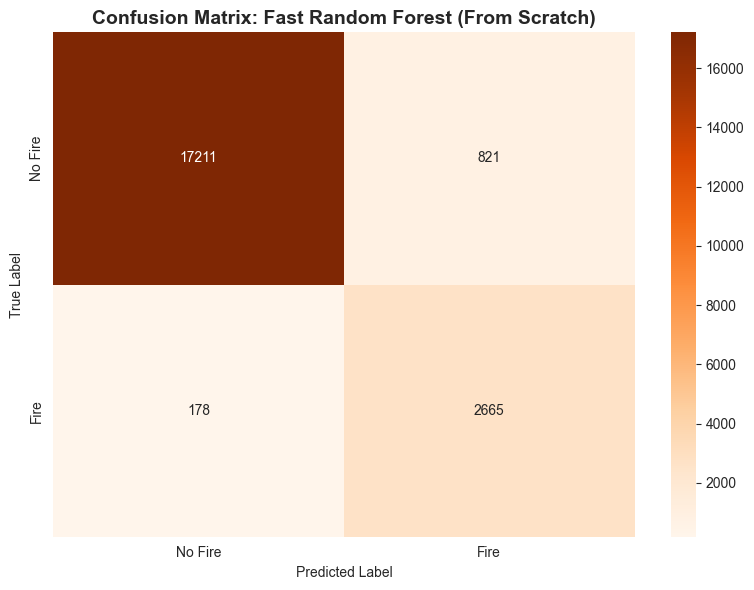

In [14]:
## 4.2 Train and Evaluate Fast Random Forest

def train_and_evaluate_fast_rf(X_train, X_test, y_train, y_test,
                                n_trees=100, max_depth=15, min_samples_split=10):
    """
    Train and evaluate optimized Random Forest.
    
    Parameters:
    -----------
    X_train, X_test : arrays
        Training and test features
    y_train, y_test : arrays
        Training and test labels
    n_trees : int
        Number of trees
    max_depth : int
        Maximum tree depth
    min_samples_split : int
        Minimum samples to split (higher = faster)
    
    Returns:
    --------
    rf : RandomForest
        Trained model
    metrics : dict
        Performance metrics
    """
    
    print(f"\n Training Random Forest from scratch...")
    print(f"   n_trees={n_trees}")
    print(f"   max_depth={max_depth}")
    print(f"   min_samples_split={min_samples_split}")
    print(f"   max_features=sqrt({X_train.shape[1]})={int(np.sqrt(X_train.shape[1]))}")
    print(f"   max_thresholds=20 (per feature)")
    
    start_time = time()
    rf = FastRandomForest(
        n_trees=n_trees,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        max_features=int(np.sqrt(X_train.shape[1])),
        max_thresholds=20
    )
    rf.fit(X_train, y_train)
    train_time = time() - start_time
    
    print(f"\n Training complete in {train_time:.2f} seconds ({train_time/60:.2f} minutes)")
    
    # Predictions
    print(" Making predictions...")
    predict_start = time()
    y_pred = rf.predict(X_test)
    predict_time = time() - predict_start
    
    print(f" Predictions complete in {predict_time:.2f} seconds")
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'train_time': train_time,
        'predict_time': predict_time
    }
    
    # Print results
    print(f"\n{'='*70}")
    print("RANDOM FOREST - PERFORMANCE")
    print(f"{'='*70}")
    print(f"Accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1']:.4f}")
    print(f"\n  Training time: {train_time:.2f}s ({train_time/60:.2f} min)")
    print(f"  Prediction time: {predict_time:.2f}s")
    
    print(f"\n Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Fire', 'Fire']))
    
    print(f"\n Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=['No Fire', 'Fire'],
                yticklabels=['No Fire', 'Fire'])
    plt.title('Confusion Matrix: Fast Random Forest (From Scratch)', 
             fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    print("="*70)
    
    return rf, metrics, y_pred

# Train Fast Random Forest with optimized parameters
rf_model, rf_metrics, rf_predictions = train_and_evaluate_fast_rf(
    X_train, X_test, y_train, y_test, 
    n_trees=100,      
    max_depth=15,     
    min_samples_split=10  
)

## 5. Model Comparison


MODEL COMPARISON (FROM SCRATCH)

📊 Performance Summary:
        Model  Accuracy  Precision   Recall  F1-Score  Train Time (s)  Predict Time (s)
Decision Tree  0.962778   0.837582 0.901512  0.868372    11073.388108          0.097842
          KNN  0.952862   0.772981 0.925783  0.842510        0.000000      15088.746618
Random Forest  0.952144   0.764487 0.937390  0.842155      585.261137          6.792938


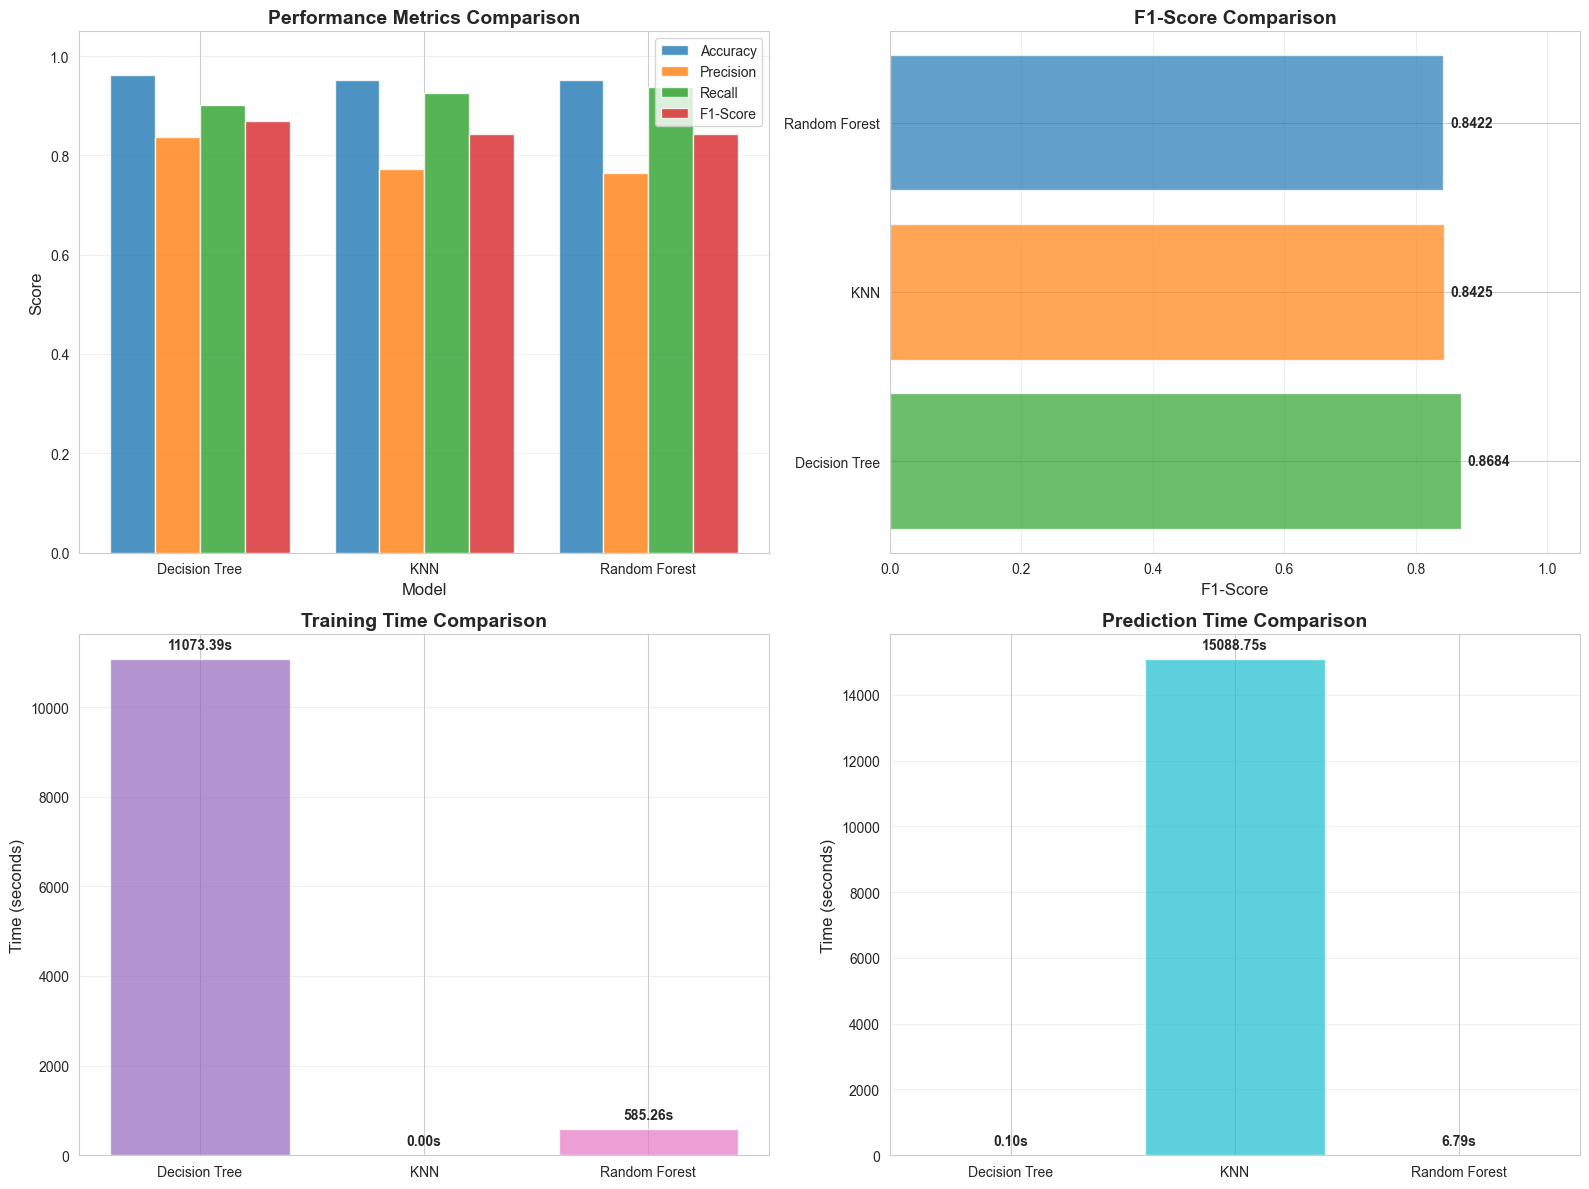


* Best Model: Decision Tree
   F1-Score: 0.8684
   Accuracy: 0.9628

 Comparison complete


In [15]:
def compare_from_scratch_models(models_metrics):
    """
    Compare all from-scratch models.
    
    Parameters:
    -----------
    models_metrics : dict
        Dictionary of model metrics
    """
    
    print("\n" + "="*70)
    print("MODEL COMPARISON (FROM SCRATCH)")
    print("="*70)
    
    # Create comparison dataframe
    comparison_data = []
    for model_name, metrics in models_metrics.items():
        comparison_data.append({
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1'],
            'Train Time (s)': metrics['train_time'],
            'Predict Time (s)': metrics['predict_time']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
    
    print("\n📊 Performance Summary:")
    print(comparison_df.to_string(index=False))
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Metrics comparison
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    x = np.arange(len(comparison_df))
    width = 0.2
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    for i, metric in enumerate(metrics_to_plot):
        axes[0, 0].bar(x + i*width, comparison_df[metric], width, 
                      label=metric, alpha=0.8, color=colors[i])
    
    axes[0, 0].set_xlabel('Model', fontsize=12)
    axes[0, 0].set_ylabel('Score', fontsize=12)
    axes[0, 0].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
    axes[0, 0].set_xticks(x + width * 1.5)
    axes[0, 0].set_xticklabels(comparison_df['Model'])
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    axes[0, 0].set_ylim([0, 1.05])
    
    # Plot 2: F1-Score comparison
    bars = axes[0, 1].barh(comparison_df['Model'], comparison_df['F1-Score'],
                           color=['#2ca02c', '#ff7f0e', '#1f77b4'], alpha=0.7)
    axes[0, 1].set_xlabel('F1-Score', fontsize=12)
    axes[0, 1].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
    axes[0, 1].grid(axis='x', alpha=0.3)
    axes[0, 1].set_xlim([0, 1.05])
    
    for i, (model, score) in enumerate(zip(comparison_df['Model'], comparison_df['F1-Score'])):
        axes[0, 1].text(score + 0.01, i, f'{score:.4f}', va='center', fontweight='bold')
    
    # Plot 3: Training time comparison
    axes[1, 0].bar(comparison_df['Model'], comparison_df['Train Time (s)'],
                   color=['#9467bd', '#8c564b', '#e377c2'], alpha=0.7)
    axes[1, 0].set_ylabel('Time (seconds)', fontsize=12)
    axes[1, 0].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    for i, (model, time) in enumerate(zip(comparison_df['Model'], comparison_df['Train Time (s)'])):
        axes[1, 0].text(i, time + max(comparison_df['Train Time (s)'])*0.02,
                       f'{time:.2f}s', ha='center', fontweight='bold')
    
    # Plot 4: Prediction time comparison
    axes[1, 1].bar(comparison_df['Model'], comparison_df['Predict Time (s)'],
                   color=['#bcbd22', '#17becf', '#d62728'], alpha=0.7)
    axes[1, 1].set_ylabel('Time (seconds)', fontsize=12)
    axes[1, 1].set_title('Prediction Time Comparison', fontsize=14, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    for i, (model, time) in enumerate(zip(comparison_df['Model'], comparison_df['Predict Time (s)'])):
        axes[1, 1].text(i, time + max(comparison_df['Predict Time (s)'])*0.02,
                       f'{time:.2f}s', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../outputs/from_scratch_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Best model
    best_model = comparison_df.iloc[0]
    print(f"\n* Best Model: {best_model['Model']}")
    print(f"   F1-Score: {best_model['F1-Score']:.4f}")
    print(f"   Accuracy: {best_model['Accuracy']:.4f}")
    
    print("\n Comparison complete")
    print("="*70)
    
    return comparison_df

# Compare all models
models_metrics = {
    'KNN': knn_metrics,
    'Decision Tree': dt_metrics,
    'Random Forest': rf_metrics
}

comparison_results = compare_from_scratch_models(models_metrics)


COMPARISON WITH SCIKIT-LEARN

 Training KNN (Scikit-learn)...
 F1-Score: 0.8425

 Training Decision Tree (Scikit-learn)...
 F1-Score: 0.8684

 Training Random Forest (Scikit-learn)...
 F1-Score: 0.8475

 Comparison Results:
                       Model  Accuracy  F1-Score   Train Time  Predict Time
               KNN (Sklearn)  0.952862  0.842510     0.009043      4.542995
     Decision Tree (Sklearn)  0.962395  0.868355     1.407619      0.003025
     Random Forest (Sklearn)  0.954060  0.847512     4.857527      0.071707
          KNN (From Scratch)  0.952862  0.842510     0.000000  15088.746618
Decision Tree (From Scratch)  0.962778  0.868372 11073.388108      0.097842
Random Forest (From Scratch)  0.952144  0.842155   585.261137      6.792938


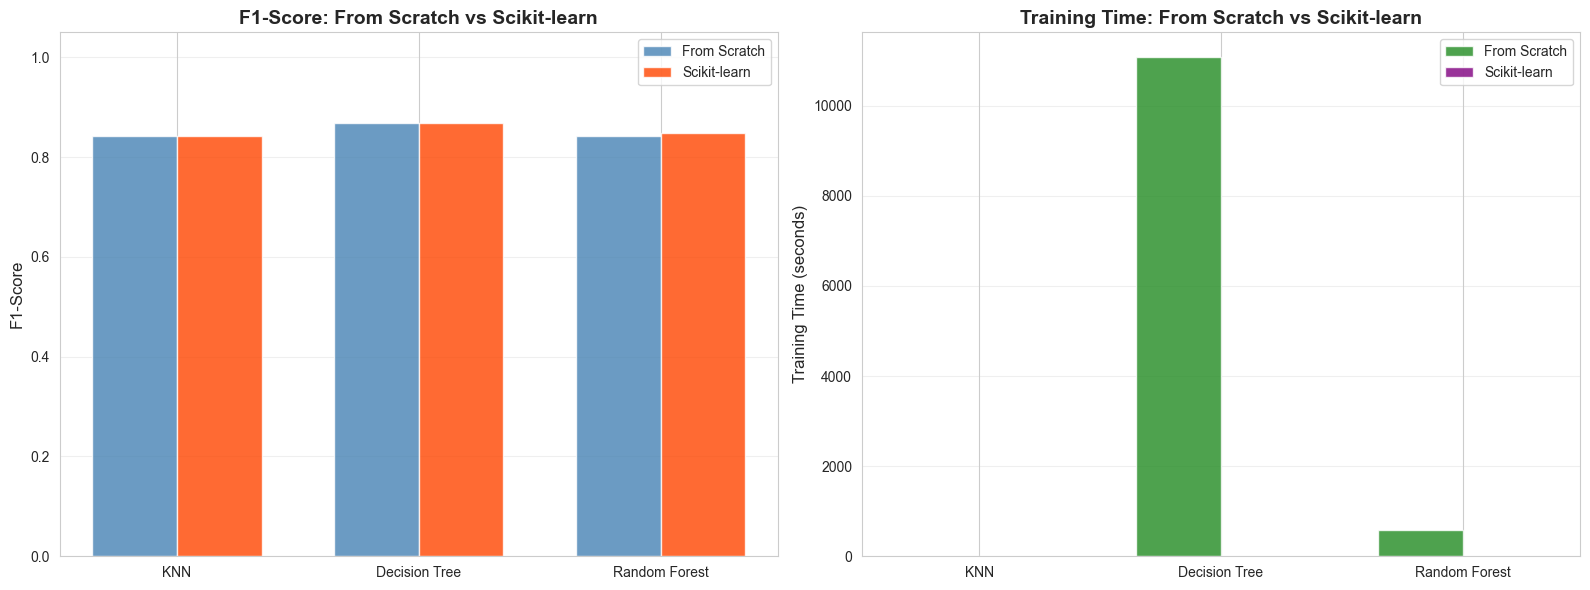


 Comparison complete


In [16]:

## 6. Comparison with Scikit-Learn

def compare_with_sklearn(X_train, X_test, y_train, y_test):
    """
    Compare from-scratch implementations with scikit-learn.
    
    Parameters:
    -----------
    X_train, X_test, y_train, y_test : arrays
        Train and test splits
    
    Returns:
    --------
    comparison_df : DataFrame
        Comparison results
    """
    
    print("\n" + "="*70)
    print("COMPARISON WITH SCIKIT-LEARN")
    print("="*70)
    
    results = []
    
    # KNN - Scikit-learn
    print("\n Training KNN (Scikit-learn)...")
    start = time()
    knn_sklearn = KNeighborsClassifier(n_neighbors=3)
    knn_sklearn.fit(X_train, y_train)
    train_time = time() - start
    
    start = time()
    y_pred = knn_sklearn.predict(X_test)
    predict_time = time() - start
    
    results.append({
        'Model': 'KNN (Sklearn)',
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Train Time': train_time,
        'Predict Time': predict_time
    })
    print(f" F1-Score: {f1_score(y_test, y_pred):.4f}")
    
    # Decision Tree - Scikit-learn
    print("\n Training Decision Tree (Scikit-learn)...")
    start = time()
    dt_sklearn = DecisionTreeClassifier(max_depth=999, min_samples_split=2, random_state=42)
    dt_sklearn.fit(X_train, y_train)
    train_time = time() - start
    
    start = time()
    y_pred = dt_sklearn.predict(X_test)
    predict_time = time() - start
    
    results.append({
        'Model': 'Decision Tree (Sklearn)',
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Train Time': train_time,
        'Predict Time': predict_time
    })
    print(f" F1-Score: {f1_score(y_test, y_pred):.4f}")
    
    # Random Forest - Scikit-learn
    print("\n Training Random Forest (Scikit-learn)...")
    start = time()
    rf_sklearn = RandomForestClassifier(
        n_estimators=100, max_depth=15, min_samples_split=10, 
        random_state=42, n_jobs=-1
    )
    rf_sklearn.fit(X_train, y_train)
    train_time = time() - start
    
    start = time()
    y_pred = rf_sklearn.predict(X_test)
    predict_time = time() - start
    
    results.append({
        'Model': 'Random Forest (Sklearn)',
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Train Time': train_time,
        'Predict Time': predict_time
    })
    print(f" F1-Score: {f1_score(y_test, y_pred):.4f}")
    
    # Add from-scratch results
    results.append({
        'Model': 'KNN (From Scratch)',
        'Accuracy': knn_metrics['accuracy'],
        'F1-Score': knn_metrics['f1'],
        'Train Time': knn_metrics['train_time'],
        'Predict Time': knn_metrics['predict_time']
    })
    
    results.append({
        'Model': 'Decision Tree (From Scratch)',
        'Accuracy': dt_metrics['accuracy'],
        'F1-Score': dt_metrics['f1'],
        'Train Time': dt_metrics['train_time'],
        'Predict Time': dt_metrics['predict_time']
    })
    
    results.append({
        'Model': 'Random Forest (From Scratch)',
        'Accuracy': rf_metrics['accuracy'],
        'F1-Score': rf_metrics['f1'],
        'Train Time': rf_metrics['train_time'],
        'Predict Time': rf_metrics['predict_time']
    })
    
    comparison_df = pd.DataFrame(results)
    
    print("\n Comparison Results:")
    print(comparison_df.to_string(index=False))
    
    # Visualize comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # F1-Score comparison
    from_scratch = comparison_df[comparison_df['Model'].str.contains('From Scratch')]
    sklearn_models = comparison_df[comparison_df['Model'].str.contains('Sklearn')]
    
    x = np.arange(3)
    width = 0.35
    
    axes[0].bar(x - width/2, from_scratch['F1-Score'].values, width, 
               label='From Scratch', color='steelblue', alpha=0.8)
    axes[0].bar(x + width/2, sklearn_models['F1-Score'].values, width,
               label='Scikit-learn', color='orangered', alpha=0.8)
    
    axes[0].set_ylabel('F1-Score', fontsize=12)
    axes[0].set_title('F1-Score: From Scratch vs Scikit-learn', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(['KNN', 'Decision Tree', 'Random Forest'])
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].set_ylim([0, 1.05])
    
    # Training time comparison
    axes[1].bar(x - width/2, from_scratch['Train Time'].values, width,
               label='From Scratch', color='forestgreen', alpha=0.8)
    axes[1].bar(x + width/2, sklearn_models['Train Time'].values, width,
               label='Scikit-learn', color='purple', alpha=0.8)
    
    axes[1].set_ylabel('Training Time (seconds)', fontsize=12)
    axes[1].set_title('Training Time: From Scratch vs Scikit-learn', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(['KNN', 'Decision Tree', 'Random Forest'])
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/from_scratch_vs_sklearn.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n Comparison complete")
    print("="*70)
    
    return comparison_df

# Compare with scikit-learn
sklearn_comparison = compare_with_sklearn(X_train, X_test, y_train, y_test)


In [19]:
## 7. Save Models

def save_models(models_dict):
    """
    Save all trained models.
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary of trained models
    """
    
    print("\n" + "="*70)
    print("SAVING MODELS")
    print("="*70)
    
    import os
    os.makedirs('../models/from_scratch/supervised', exist_ok=True)
    
    for model_name, model in models_dict.items():
        filepath = f'../models/from_scratch/supervised/{model_name.lower().replace(" ", "_")}_model.pkl'
        
        with open(filepath, 'wb') as f:
            pickle.dump(model, f)
        
        print(f" {model_name} saved: {filepath}")
    
    # Save scaler
    scaler_path = '../models/from_scratch/supervised/scaler.pkl'
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f" Scaler saved: {scaler_path}")
    
    print("\n" + "="*70)

# Save all models
models_to_save = {
    'KNN': knn_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model
}

save_models(models_to_save)



SAVING MODELS
 KNN saved: ../models/from_scratch/supervised/knn_model.pkl
 Decision Tree saved: ../models/from_scratch/supervised/decision_tree_model.pkl
 Random Forest saved: ../models/from_scratch/supervised/random_forest_model.pkl
 Scaler saved: ../models/from_scratch/supervised/scaler.pkl



In [20]:

## 8. Save Results to CSV
def save_results_to_csv(comparison_df, sklearn_comparison):
    """
    Save all results to CSV files.
    
    Parameters:
    -----------
    comparison_df : DataFrame
        From-scratch model comparison
    sklearn_comparison : DataFrame
        Sklearn comparison results
    """
    
    print("\n" + "="*70)
    print("SAVING RESULTS TO CSV")
    print("="*70)
    
    import os
    os.makedirs('../outputs/from_scratch_results/supervised', exist_ok=True)
    
    # Save from-scratch comparison
    path1 = '../outputs/from_scratch_results/supervised/from_scratch_comparison.csv'
    comparison_df.to_csv(path1, index=False)
    print(f" From-scratch comparison saved: {path1}")
    
    # Save sklearn comparison
    path2 = '../outputs/from_scratch_results/supervised/sklearn_comparison.csv'
    sklearn_comparison.to_csv(path2, index=False)
    print(f" Sklearn comparison saved: {path2}")
    
    # Save detailed metrics for each model
    detailed_metrics = pd.DataFrame([
        {
            'Model': 'KNN',
            'Implementation': 'From Scratch',
            **knn_metrics
        },
        {
            'Model': 'Decision Tree',
            'Implementation': 'From Scratch',
            **dt_metrics
        },
        {
            'Model': 'Random Forest',
            'Implementation': 'From Scratch',
            **rf_metrics
        }
    ])
    
    path3 = '../outputs/from_scratch_results/supervised/detailed_metrics.csv'
    detailed_metrics.to_csv(path3, index=False)
    print(f" Detailed metrics saved: {path3}")
    
    # Save predictions
    predictions_df = pd.DataFrame({
        'true_label': y_test,
        'knn_prediction': knn_predictions,
        'dt_prediction': dt_predictions,
        'rf_prediction': rf_predictions
    })
    
    path4 = '../outputs/from_scratch_results/supervised/predictions.csv'
    predictions_df.to_csv(path4, index=False)
    print(f" Predictions saved: {path4}")
    
    print("\n All results saved to: ../outputs/from_scratch_results/supervised/")
    print("="*70)

# Save all results
save_results_to_csv(comparison_results, sklearn_comparison)


SAVING RESULTS TO CSV
 From-scratch comparison saved: ../outputs/from_scratch_results/supervised/from_scratch_comparison.csv
 Sklearn comparison saved: ../outputs/from_scratch_results/supervised/sklearn_comparison.csv
 Detailed metrics saved: ../outputs/from_scratch_results/supervised/detailed_metrics.csv
 Predictions saved: ../outputs/from_scratch_results/supervised/predictions.csv

 All results saved to: ../outputs/from_scratch_results/supervised/
